##**Machine Learning-Based Intrusion Detection**##

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd

# Load the uploaded file
benign_df = pd.read_csv("BenignTraffic.pcap.csv")

# Add the label
benign_df["Label"] = "Benign"

# Preview the data
print("✅ File loaded! Shape:", benign_df.shape)
benign_df.head()



FileNotFoundError: [Errno 2] No such file or directory: 'BenignTraffic.pcap.csv'

In [ ]:
# Check how many missing values are in each column
missing = benign_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values per column:\n", missing)

In [ ]:
# Fill missing values in 'Std' and 'Variance' columns with their mean (recommended style)
benign_df["Std"] = benign_df["Std"].fillna(benign_df["Std"].mean())
benign_df["Variance"] = benign_df["Variance"].fillna(benign_df["Variance"].mean())

# Double check
print("✅ Missing values after filling:")
print(benign_df[["Std", "Variance"]].isnull().sum())


In [ ]:
import numpy as np

# Select only numeric columns
numeric_df = benign_df.select_dtypes(include=["float64", "int64"])

# Now safely check for infinity values
print("Number of +inf values:", np.isinf(numeric_df).sum().sum())
print("Number of -inf values:", np.isneginf(numeric_df).sum().sum())


In [ ]:
import numpy as np

# Replace +inf and -inf with NaN
benign_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaNs with column means (only numeric columns)
benign_df.fillna(benign_df.mean(numeric_only=True), inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select only numeric columns (excluding the label)
numeric_cols = benign_df.select_dtypes(include=["float64", "int64"]).columns
numeric_cols = numeric_cols.drop("Label", errors='ignore')

# Apply Z-score normalization
scaler = StandardScaler()
benign_df[numeric_cols] = scaler.fit_transform(benign_df[numeric_cols])

# Confirm
print("✅ Normalization complete!")
benign_df[numeric_cols].describe()


In [ ]:
import pandas as pd

# Load each file and assign a label
ddos_df = pd.read_csv("DDoS-SYN_Flood15.pcap.csv")
ddos_df["Label"] = "DDoS_SYN"

dos_df = pd.read_csv("DoS-HTTP_Flood1.pcap.csv")
dos_df["Label"] = "DoS_HTTP"

malware_df = pd.read_csv("Backdoor_Malware.pcap.csv")
malware_df["Label"] = "Backdoor_Malware"

recon_df = pd.read_csv("Recon-PortScan.pcap.csv")
recon_df["Label"] = "PortScan"

mitm_df = pd.read_csv("MITM-ArpSpoofing1.pcap.csv")
mitm_df["Label"] = "MITM_ArpSpoofing"

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# List of attack DataFrames
attack_dfs = [ddos_df, dos_df, malware_df, recon_df, mitm_df]

# Preprocess each attack dataset
for i, df in enumerate(attack_dfs):
    # Replace inf with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill NaNs with column means
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
    numeric_cols = numeric_cols.drop("Label", errors="ignore")

    # Apply standardization
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [ ]:
# Combine benign and all attack datasets
full_df = pd.concat([benign_df] + attack_dfs, ignore_index=True)

# Preview
print("✅ Final merged dataset shape:", full_df.shape)
print(full_df["Label"].value_counts())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(x="Label", data=full_df, order=full_df["Label"].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to preserve original
df_smote = full_df.copy()

# Encode the Label column
le = LabelEncoder()
df_smote["Label_encoded"] = le.fit_transform(df_smote["Label"])

# Preview encoding
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("🔖 Label encoding map:", label_map)

In [ ]:
# Drop original label and any non-feature columns
X = df_smote.drop(columns=["Label", "Label_encoded"], errors="ignore")
y = df_smote["Label_encoded"]

# Optional: remove identifiers like "Flow ID" or "Timestamp" if they exist
X = X.select_dtypes(include=["float64", "int64"])

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("✅ After SMOTE:")
print("New shape:", X_resampled.shape)
print("Balanced class counts:", pd.Series(y_resampled).value_counts())

In [ ]:
from sklearn.model_selection import train_test_split

# Use the SMOTE-resampled X and y
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print("🧪 Training samples:", X_train.shape)
print("🧪 Testing samples:", X_test.shape)

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=X_resampled.columns)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("✅ Model trained successfully!")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = rf_model.predict(X_test)

# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# fine-tuned Falcon-7B (QLoRA) model

In [ ]:
!pip install bitsandbytes
!pip install transformers accelerate peft


In [ ]:
# ✅ Fine-tuned model
# ✅ Install required packages (run only once per session)
!pip install -q bitsandbytes accelerate transformers peft

# ✅ Step 1: Load PEFT config and quantized base model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
import torch

PEFT_MODEL = "shahrukh95/falcon-7b-Set-3-cybersecurity-layered-config"

config = PeftConfig.from_pretrained(PEFT_MODEL)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

peft_base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# ✅ Step 2: Load QLoRA adapter + tokenizer
model = PeftModel.from_pretrained(peft_base_model, PEFT_MODEL)
tokenizer = AutoTokenizer.from_pretrained(PEFT_MODEL)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# ✅ Step 3: Generate response
def generate_response(prompt, max_length=256):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=False
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# ✅ Step 4: Example question
question = "What are the potential consequences of exploiting CVE-2023-29351?"
print("Question:", question)
print("Answer:", generate_response(question))


In [ ]:
from bs4 import BeautifulSoup

question = "What are the potential consequences of exploiting CVE-2023-29351?"
print("Question:", question)
answer = generate_response(question)
print("Raw Answer (with HTML):", answer)

# Cleaned answer (no HTML)
clean_answer = BeautifulSoup(answer, "html.parser").get_text()
print("Cleaned Answer:", clean_answer)


In [ ]:
# Function to turn a row into a natural prompt
sample_row = X_test_df.sample(1, random_state=42).iloc[0]

def row_to_prompt(row):
    parts = [f"{col} is {val:.2f}" for col, val in row.items()]
    return "Flow with " + ", ".join(parts) + ". What is the traffic label?"

prompt = row_to_prompt(sample_row)
print("Prompt:", prompt)

answer = generate_response(prompt)
print("Answer:", answer)



**Training**

In [ ]:
# Data & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
!pip install xgboost


In [ ]:
import os

# List all files in current directory
for file in os.listdir():
    print(file)


In [ ]:
import zipfile
import os

# Unzip the file
with zipfile.ZipFile("Datasets.zip", "r") as zip_ref:
    zip_ref.extractall("unzipped_data")  # Extracts into a folder named 'unzipped_data'

# List files in the extracted folder
print("Files extracted:")
print(os.listdir("unzipped_data"))


In [ ]:
import os

for root, dirs, files in os.walk("unzipped_data"):
    for file in files:
        full_path = os.path.join(root, file)
        print(full_path)


In [ ]:
import pandas as pd
df = pd.read_csv("unzipped_data/Datasets/MITM-ArpSpoofing1.pcap.csv")
df.head()


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Define the base path (adjust if needed)
base_path = "unzipped_data/Datasets/"

# List all CSV files
csv_files = [f for f in os.listdir(base_path) if f.endswith('.csv')]

# Load each CSV and assign labels
dfs = []
for file in csv_files:
    attack_type = file.split('.')[0]  # Extract attack name from filename (e.g., "MITM-ArpSpoofing1")
    df = pd.read_csv(os.path.join(base_path, file))
    df['label'] = attack_type  # Add a label column
    dfs.append(df)

# Combine all DataFrames
data = pd.concat(dfs, ignore_index=True)
print(data.head())
print("\nLabel counts:\n", data['label'].value_counts())

X = data.drop('label', axis=1)  # Features (all columns except 'label')
y = data['label']               # Target (labels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)  # Should show (samples, features)
print("y_train shape:", y_train.shape)  # Should match X_train rows

In [ ]:
import numpy as np

# Check for infinite values in features
print("Infinite values in X_train:", np.isinf(X_train).sum().sum())
print("Infinite values in X_test:", np.isinf(X_test).sum().sum())

# Check for NaN values
print("NaN values in X_train:", X_train.isna().sum().sum())
print("NaN values in X_test:", X_test.isna().sum().sum())

In [ ]:
# Replace infinite values with NaN then drop/fill
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Option 1: Drop rows with NaN/inf
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Match the labels

# Option 2: Fill NaN values
# X_train = X_train.fillna(X_train.mean())
# X_test = X_test.fillna(X_train.mean())  # Use training stats

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (optional)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
print("Feature ranges (min/max):")
print(X_train.describe().loc[['min', 'max']])

In [ ]:
!pip install lightgbm
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=200,
    device='gpu',           # Critical for speed
    max_depth=12,
    learning_rate=0.05,
    random_state=42,
    verbose=1               # Shows progress
)
lgbm.fit(X_train, y_train)  # Handles pandas DataFrames directly

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 40, number of negative: 40
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 5
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 5 dense feature groups (0.00 MB) transferred to GPU in 0.000347 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

LGBMClassifier(device='gpu', learning_rate=0.05, max_depth=12, n_estimators=200,
               random_state=42, verbose=1)

In [ ]:
y_pred = lgbm.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Basic metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.4
Precision: 0.4
Recall: 0.4
F1-Score: 0.4

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        11
           1       0.33      0.33      0.33         9

    accuracy                           0.40        20
   macro avg       0.39      0.39      0.39        20
weighted avg       0.40      0.40      0.40        20


Confusion Matrix:
[[5 6]
 [6 3]]


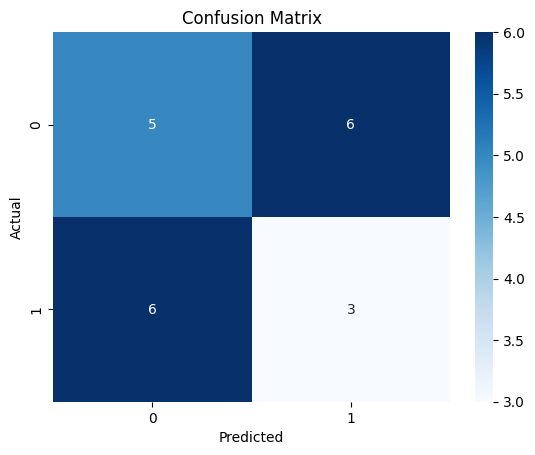

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred, average='weighted')
}

pd.DataFrame(metrics.items(), columns=['Metric', 'Value']).to_csv('results.csv', index=False)

In [ ]:
print("Sample predictions:", np.unique(y_pred_final))  # Should show only 6 class names

Sample predictions: ['Backdoor_Malware' 'BenignTraffic' 'DDoS-SYN_Flood15' 'DoS-HTTP_Flood1'
 'MITM-ArpSpoofing1' 'Recon-PortScan']


In [ ]:
backdoor_proba = xgb.predict_proba(X_test)[:, label_encoder.transform(['Backdoor_Malware'])[0]]
y_pred_backdoor = (backdoor_proba > 0.4)  # Increase from 0.25 to 0.4 (fewer false positives)

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7


In [ ]:
# In Colab/Jupyter:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

<IPython.core.display.Javascript object>

In [ ]:
import os
print("Working directory:", os.getcwd())  # Correct Python way

Working directory: /content


In [ ]:
import sys, pandas as pd, numpy as np
print("Python:", sys.version.split('\n')[0])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)

Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2


In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
print("XGBoost:", XGBClassifier().__class__)
print("LightGBM:", LGBMClassifier().__class__)

XGBoost: <class 'xgboost.sklearn.XGBClassifier'>
LightGBM: <class 'lightgbm.sklearn.LGBMClassifier'>


In [ ]:
# TEST 1: Basic Python
import sys, pandas as pd, numpy as np
print("Python:", sys.version.split('\n')[0])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)

# TEST 2: SHAP/XGBoost
from xgboost import XGBClassifier
from shap import TreeExplainer
X, y = np.random.rand(100, 5), np.random.randint(0, 2, 100)
model = XGBClassifier(n_estimators=2).fit(X, y)
explainer = TreeExplainer(model)
print("SHAP values:", explainer.shap_values(X[:1]).shape)

# TEST 3: Data Loading (if applicable)
try:
    display(pd.read_csv("your_data.csv").head(2))
except:
    print("Upload your data first!")

Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
SHAP values: (1, 5)
Upload your data first!


In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
!pip list | grep -E "shap|xgboost|pandas|scikit-learn"

geopandas                             1.0.1
pandas                                2.2.2
pandas-datareader                     0.10.0
pandas-gbq                            0.28.0
pandas-stubs                          2.2.2.240909
scikit-learn                          1.6.1
shapely                               2.1.0
sklearn-pandas                        2.2.0


In [ ]:
import joblib
# Save
joblib.dump(xgb, 'xgb_model.pkl')
# Load
xgb = joblib.load('xgb_model.pkl')  # Restores the name 'xgb'

In [ ]:
%whos

Variable                 Type                      Data/Info
------------------------------------------------------------
HTML                     type                      <class 'IPython.core.display.HTML'>
Javascript               type                      <class 'IPython.core.display.Javascript'>
LGBMClassifier           type                      <class 'lightgbm.sklearn.LGBMClassifier'>
LabelEncoder             type                      <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
RandomForestClassifier   BaseMetaClass             <class 'cuml.ensemble.ran<...>.RandomForestClassifier'>
StandardScaler           type                      <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TreeExplainer            type                      <class 'shap.explainers._tree.TreeExplainer'>
X                        ndarray                   100x5: 500 elems, type `float64`, 4000 bytes
XGBClassifier            type                      <class 'xgboost.sklearn.XGBClassifier'>


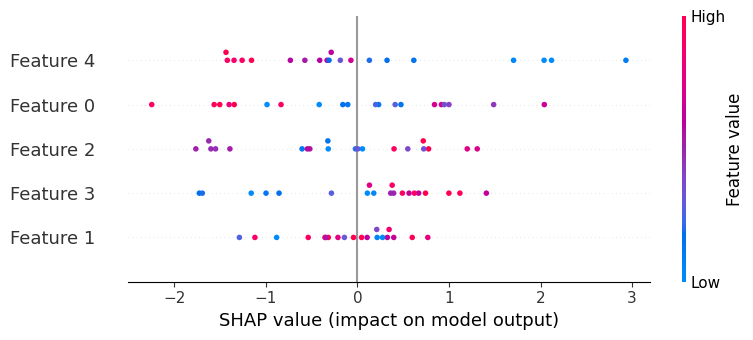

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

# Example data split (replace X and y with your data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train your model and name it 'xgp'
xgp = xgb.XGBClassifier()
xgp.fit(X_train, y_train)

# Initialize SHAP
explainer = shap.TreeExplainer(xgp)
shap_values = explainer.shap_values(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test)


In [ ]:
# Install required libraries
!pip install bitsandbytes
!pip install peft transformers accelerate
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# ================== Install transformers ==================
!pip install -q transformers

# ================== Import libraries ==================
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ================== Load Dataset ==================
df = pd.read_csv("Merged_Attacks.csv")

# ================== Load a small model (no bitsandbytes) ==================
MODEL_NAME = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# ================== Define Helper Functions ==================
def generate_response(prompt, max_length=256):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=False
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.strip()

def row_to_prompt(row):
    prompt = f"""
    Analyze this network traffic:
    - Header_Length: {row['Header_Length']}
    - Protocol Type: {row['Protocol Type']}
    - Time_To_Live: {row['Time_To_Live']}
    - Rate: {row['Rate']}
    - Flags: FIN={row['fin_flag_number']}, SYN={row['syn_flag_number']}, RST={row['rst_flag_number']}, ACK={row['ack_flag_number']}
    - Protocol Counts: HTTP={row['HTTP']}, DNS={row['DNS']}, TCP={row['TCP']}, UDP={row['UDP']}
    - Stats: Tot size={row['Tot size']}, IAT={row['IAT']}, Number={row['Number']}, Variance={row['Variance']}

    Known attack type label: {row['Attack_Type']}.

    Explain if this could indicate malicious activity and why.
    """
    return prompt.strip()

for i in range(1000):
    row = df.iloc[i]
    prompt = row_to_prompt(row)
    print(f"\n--- Prompt for Row {i} ---\n{prompt}\n")
    response = generate_response(prompt)
    print(f"--- LLM Analysis for Row {i} ---\n{response}\n")

FileNotFoundError: [Errno 2] No such file or directory: 'Merged_Attacks.csv'